In [1]:
import numpy as np
import os
import random
from tqdm.auto import tqdm
import cv2
import pyarrow.parquet as pq
import glob
import math
import cupy as cp
from einops import rearrange
import time as time

c:\Users\ML_RTC\Desktop\Tau\work\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
file = pq.ParquetFile("./Data_Raw_Tau/DYToTauTau_M-10_13TeV_pythia8_2018/DYToTauTau_M-10_13TeV_pythia8_2018_3.parquet")
batch = file.iter_batches(256)
batch = next(batch)
batch = batch.to_pandas()
meta = np.array(batch.iloc[:, 1])

In [8]:
batch

,y,pv,gen_prongs,X_jet,gen_pT
0,1.0,28.0,1.0,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",48.832783
1,1.0,19.0,1.0,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",27.424585
2,1.0,15.0,1.0,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",31.202829
3,1.0,34.0,1.0,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",22.453835
4,1.0,17.0,1.0,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.831943...",23.492826
...,...,...,...,...,...
251,1.0,30.0,1.0,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",42.770519
252,1.0,26.0,1.0,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",52.777267
253,1.0,23.0,1.0,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",11.009419
254,1.0,14.0,1.0,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",6.730433


In [3]:
file = pq.ParquetFile("./Data_Raw_Tau/DYToTauTau_M-10_13TeV_pythia8_2018/DYToTauTau_M-10_13TeV_pythia8_2018_0.parquet")


In [9]:
batch = file.read_row_groups(np.arange(0,2048))
# batch = batch.to_pydict()

In [28]:
im = np.array(batch["X_jet"])

In [29]:
im.shape

(10, 13, 125, 125)

In [23]:
im.shape
import matplotlib.pyplot as plt

In [10]:
y = rearrange(im, 'b c h w -> b h w c')
print(y.shape)
test = y.copy()
test = rearrange(test, 'b h w c -> b h ( w c )')
test2 = test.copy()
test2 = rearrange(test2, 'b h ( w c ) -> b h w c', w = 125, c=13)

(256, 125, 125, 13)


In [31]:
test.shape

(32, 125, 1625)

In [8]:
(test2.get() == y.get()).all()

True

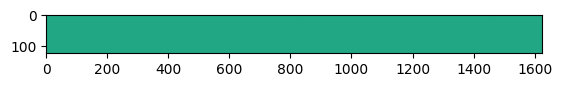

In [34]:
plt.imshow(test[0,:,:].get())

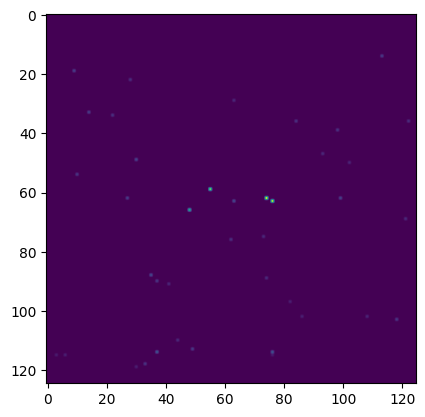

In [25]:
plt.imshow(y[0,:,:,0].get())

In [4]:
iter_batch_time =[]
batch_to_pandas_time = []
im_extractor_time =[]
saver_chunk_1_time = []
saver_chunk_2_time =[]

In [2]:

BATCH_SIZE = 2048
def generate(pf, path, a):
    record_batch = pf.iter_batches(batch_size=BATCH_SIZE)
    while True:
        try:
            a_ = time.time()
            batch = next(record_batch)
            b_ = time.time()
            iter_batch_time.append(b_-a_)
            ab = transform(batch, path,a)

        except StopIteration:
            # print("Done")
            return ab

def transform(batch,path, a):
    a_ = time.time()
    p = batch.to_pandas()
    b_ = time.time()
    batch_to_pandas_time.append(b_-a_)
    a_ = time.time()
    im = cp.array(np.array(np.array(p.iloc[:, 3].tolist()).tolist()).tolist())
    meta = np.array(p.iloc[:,0])
    b_ = time.time()
    im_extractor_time.append(b_-a_)
    return saver(im,meta, path, a)


def saver(im, meta, path, a):
    alpha = a
    a_ = time.time()
    im[im < 1.e-3] = 0 #Zero_suppression
    im = rearrange(im, 'b c h w -> b h w c')
    for _z in range(13):
        im[:,:,:,_z] = (im[:,:,:,_z] - im[:,:,:,_z].mean())/(im[:,:,:,_z].std())
        im[:,:,:,_z] = cp.clip(im[:,:,:,_z], a_min = 0, a_max = 500*im[:,:,:,_z].std(axis = (1,2))[:,None,None])

    b_ = time.time()
    saver_chunk_1_time.append(b_ - a_)
    im = im.get()
    a_ = time.time()
    for i in range(meta.shape[0]):
        img = im[i,:,:,:]
        for _z in range(13):
            
            if (img[:,:,_z]==0).all() == False:
                img[:,:,_z] = 255*(img[:,:,_z])/(img[:,:,_z].max())



        img = img.astype(np.uint8)
        img = rearrange(img, 'h w c -> h ( w c )')
        alpha = alpha +1
        impath = os.path.join(path,str(str(alpha)+".png"))
        cv2.imwrite(impath , img)
    b_ = time.time()
    saver_chunk_2_time.append(b_ - a_)
    return alpha


def runner(source, target):
    """
    Fuction to convert all the Parquet Files in a given folder to .png format Files
    Args:
    source: The souce folder of the Parquet Files
    target: The target folder where the dataset will be stored
    """
    a = 0
    
    files = os.listdir(source)
    print("The following files were found in the provided Directory")
    print(files)
    for i in range(len(files)):
        a = generate(pq.ParquetFile(os.path.join(source, files[i])), target, a)
    print("The files were successfully generated")

In [5]:
runner("C:/Users/ML_RTC/Desktop/Tau/data/Raw-Data/Data_Raw_Tau/WJetsToLNu_13TeV_2018/",
       "C:/Users/ML_RTC/Desktop/Tau/data/Raw-Data/Data_extracted/WJetsToLNu_13TeV_2018/")

The following files were found in the provided Directory
['DYToTauTau_M-10_13TeV_pythia8_2018_ext1_0.parquet', 'DYToTauTau_M-10_13TeV_pythia8_2018_ext1_1.parquet', 'DYToTauTau_M-10_13TeV_pythia8_2018_ext1_2.parquet', 'DYToTauTau_M-10_13TeV_pythia8_2018_ext1_3.parquet', 'DYToTauTau_M-10_13TeV_pythia8_2018_ext1_4.parquet']


KeyboardInterrupt: 

In [5]:
iter_batch_time

[8.411536931991577,
 11.97896695137024,
 10.307440280914307,
 10.322402238845825,
 12.163478136062622,
 10.882900714874268,
 8.485320329666138,
 9.075734376907349,
 9.078756332397461,
 9.82174038887024]

In [6]:
batch_to_pandas_time


[1.3364002704620361,
 0.8687012195587158,
 0.8616964817047119,
 0.8357930183410645,
 0.849754810333252,
 0.8427455425262451,
 0.8367645740509033,
 0.7978646755218506,
 0.8297486305236816,
 0.832772970199585]

In [7]:
im_extractor_time 


[11.230969905853271,
 7.8639678955078125,
 6.683130264282227,
 6.097667932510376,
 5.961036205291748,
 5.222036600112915,
 5.360100030899048,
 5.467889070510864,
 4.9776928424835205,
 6.98036527633667]

In [8]:
saver_chunk_1_time 


[0.7499935626983643,
 0.42384862899780273,
 0.4857330322265625,
 0.4597971439361572,
 0.4837327003479004,
 0.4118998050689697,
 0.439821720123291,
 0.4916865825653076,
 0.5176188945770264,
 0.40987396240234375]

In [9]:
saver_chunk_2_time

[8.499124765396118,
 8.28037714958191,
 8.453978538513184,
 8.262742519378662,
 8.404086112976074,
 8.225054502487183,
 8.257432222366333,
 8.353331565856934,
 8.08635926246643,
 8.186665534973145]